In [1]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
df_news=pd.read_csv('C:/Users/Azerty/Desktop/Fake news detection/data/train_news.csv',index_col=0)
df_news

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...
20791,Lawyer Who Kept Hillary Campaign Chief Out of ...,Daniel Greenfield,Lawyer Who Kept Hillary Campaign Chief Out of ...,1
20792,"Jakarta Bombing Kills Three Police Officers, L...",John Hayward,Two suicide bombers attacked a bus station in ...,0
20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0


In [3]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16640 entries, 0 to 20798
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   16194 non-null  object
 1   author  15071 non-null  object
 2   text    16610 non-null  object
 3   label   16640 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 650.0+ KB


In [4]:
# number of nan values
df_news.isna().sum()

title      446
author    1569
text        30
label        0
dtype: int64

In [5]:
# Number of rows with nan values in title and text columns
df_news[['title','text']].isna().all(1).sum()

0

In [6]:
df_news.fillna('0',inplace=True)
df_news['original_text']=df_news['title']+' '+df_news['text']
df_news.drop(columns=['author','text','title'],inplace=True)

In [7]:
#tokonization
df_news['tokenized_text'] = df_news.apply(lambda x: word_tokenize(x['original_text'].lower()),axis=1)
df_news.drop(columns=['original_text'],inplace=True)

In [8]:
stopwords_list=stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def process(list_word):
    
    #delete stop words
    filtered_sentence =[word for word in list_word if word not in stopwords_list ]
    #delete punctuation
    filtered_sentence = [word for word in filtered_sentence  if word.isalnum()]
    #lemitization
    filtered_sentence = [lemmatizer.lemmatize(word) for word in filtered_sentence]
    
    return filtered_sentence

df_news['tokenized_text']=df_news.apply(lambda x: process(x['tokenized_text']),axis=1)




## WordCloud

In [9]:
## wordcloud : for text (fake)
fake_text_list=df_news[df_news['label']==0]['tokenized_text']
fake_frequency_series= pd.Series([y for x in fake_text_list  for y in x]).value_counts()

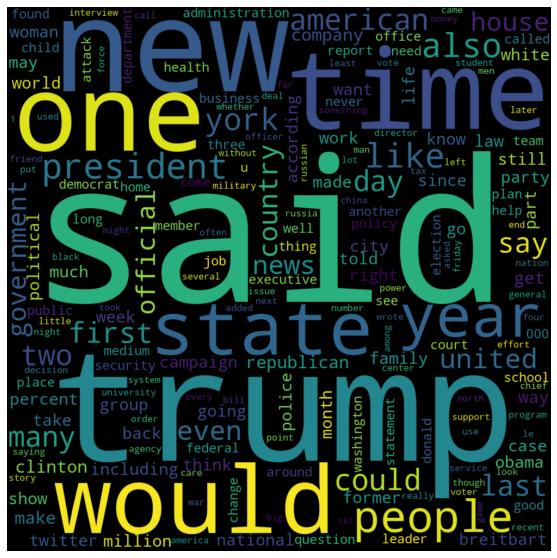

In [10]:
# generate the world wloud for fake news

wordcloud = WordCloud(width=1000,height=1000)
wordcloud.generate_from_frequencies(frequencies=fake_frequency_series)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

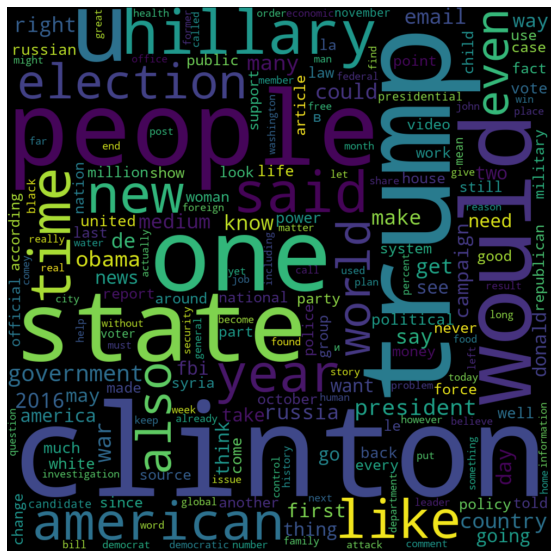

In [11]:
## wordcloud : for text (real)
real_text_list=df_news[df_news['label']==1]['tokenized_text']
real_frequency_series= pd.Series([y for x in real_text_list  for y in x]).value_counts()

#generate the world cloud for real news
wordcloud.generate_from_frequencies(frequencies=real_frequency_series)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Word2vec model

In [12]:
# word embedding using word2vec
W2vecmodel = Word2Vec(sentences=df_news['tokenized_text'], vector_size=100, window=5, min_count=1, workers=4)

# Retrieve the weights from the model. This is used for initializing the weights
# in a Keras Embedding layer later
vocab_size, embedding_size = W2vecmodel.wv.vectors.shape

print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 146077 - Embedding Dim: 100


In [13]:
# test

vector = W2vecmodel.wv['trump']  # get numpy vector of a word
similars = W2vecmodel.wv.most_similar('trump', topn=10)
similars

[('arnie', 0.5850045084953308),
 ('tump', 0.5689602494239807),
 ('clinton', 0.5681737065315247),
 ('rosenshein', 0.56376713514328),
 ('candidacy', 0.5352067351341248),
 ('penny', 0.5339890718460083),
 ('opponent', 0.5259444117546082),
 ('donald', 0.5213893055915833),
 ('incoming', 0.5203477144241333),
 ('odds', 0.5142323970794678)]

In [14]:
df_news

,label,tokenized_text
id,,
0,1,"[house, dem, aide, even, see, comey, letter, j..."
1,0,"[flynn, hillary, clinton, big, woman, campus, ..."
2,1,"[truth, might, get, fired, truth, might, get, ..."
3,1,"[15, civilian, killed, single, u, airstrike, i..."
4,1,"[iranian, woman, jailed, fictional, unpublishe..."
...,...,...
20791,1,"[lawyer, kept, hillary, campaign, chief, jail,..."
20792,0,"[jakarta, bombing, kill, three, police, office..."
20795,0,"[rapper, trump, poster, child, white, supremac..."


In [15]:
# text to sequance (for lstm)

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df_news['tokenized_text'])
df_news['tokenized_text']=tokenizer.texts_to_sequences(df_news['tokenized_text'])

In [16]:
df_news['tokenized_text']

id
0        [40, 4400, 880, 18, 58, 348, 534, 2566, 6347, ...
1        [2015, 25, 10, 195, 44, 1402, 152, 286, 27, 11...
2        [597, 136, 27, 1262, 597, 136, 27, 1262, 287, ...
3        [658, 686, 399, 666, 15, 5675, 1542, 158, 658,...
4        [1667, 44, 6160, 8156, 19806, 159, 44, 22306, ...
                               ...                        
20791    [466, 1071, 25, 37, 238, 1657, 2888, 25, 2671,...
20792    [14692, 1498, 1094, 121, 80, 165, 1988, 372, 4...
20795    [5278, 2, 4101, 95, 41, 5603, 5278, 17538, 131...
20797    [7206, 1, 1387, 4389, 881, 3722, 2267, 6, 34, ...
20798    [875, 69, 551, 4291, 1550, 6146, 875, 69, 551,...
Name: tokenized_text, Length: 16640, dtype: object

<AxesSubplot:ylabel='Count'>

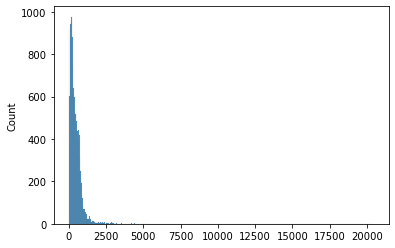

In [17]:
# number of word per text
sns.histplot([len(word) for word in df_news['tokenized_text']])

In [18]:
Arr=np.array([len(word) for word in df_news['tokenized_text']])
len(Arr[Arr>1500])

341

In [19]:
X=pad_sequences(df_news['tokenized_text'],maxlen=1500) # i choosed as text size 1500 : text with more than 1500 will be trunked and text with less than 1500 will be padded
y=df_news['label']

In [20]:
def matrixweight(W2vecmodel):
    matrix=np.zeros((vocab_size+1,100))
    for i, word in tokenizer.index_word.items():
        matrix[i]=W2vecmodel.wv[word]
    return matrix

embedding_matrix=matrixweight(W2vecmodel)

# LSTM model

In [21]:
# LSTM model


model = keras.models.Sequential()
model.add(layers.Embedding(input_dim=vocab_size+1, output_dim=embedding_size,weights=[embedding_matrix],trainable=False,input_length=1500,mask_zero=True))
model.add(layers.LSTM(128))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1500, 100)         14607800  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 14,725,177
Trainable params: 117,377
Non-trainable params: 14,607,800
_________________________________________________________________


In [22]:
# training
history=model.fit(X,y, validation_split=0.2,epochs=6)

Epoch 1/6
416/416 [==============================] - 1048s 3s/step - loss: 0.4002 - accuracy: 0.8108 - val_loss: 0.3533 - val_accuracy: 0.8407
Epoch 2/6
416/416 [==============================] - 878s 2s/step - loss: 0.3073 - accuracy: 0.8700 - val_loss: 0.2687 - val_accuracy: 0.8813
Epoch 3/6
416/416 [==============================] - 1033s 2s/step - loss: 0.2113 - accuracy: 0.9160 - val_loss: 0.1833 - val_accuracy: 0.9273
Epoch 4/6
416/416 [==============================] - 1065s 3s/step - loss: 0.1781 - accuracy: 0.9304 - val_loss: 0.2715 - val_accuracy: 0.8807
Epoch 5/6
416/416 [==============================] - 1103s 3s/step - loss: 0.1567 - accuracy: 0.9419 - val_loss: 0.1295 - val_accuracy: 0.9516
Epoch 6/6
416/416 [==============================] - 977s 2s/step - loss: 0.0857 - accuracy: 0.9699 - val_loss: 0.0901 - val_accuracy: 0.9688


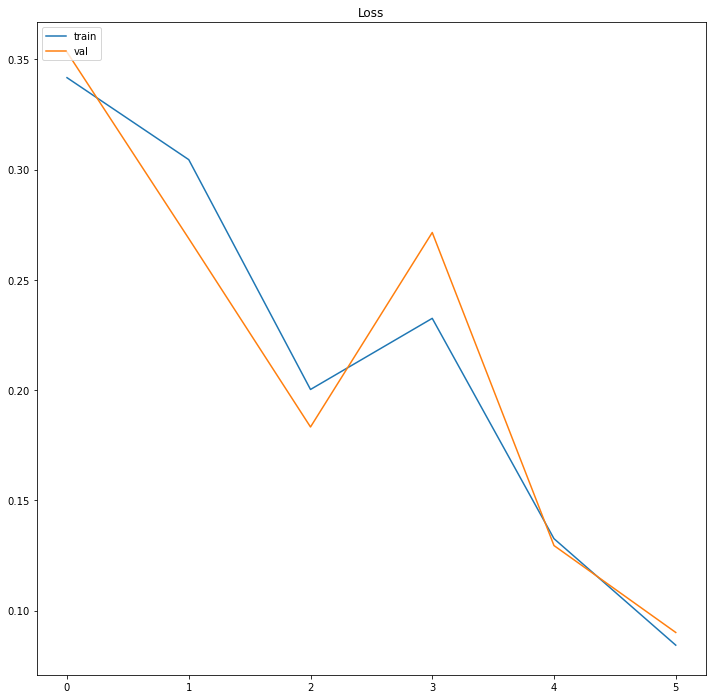

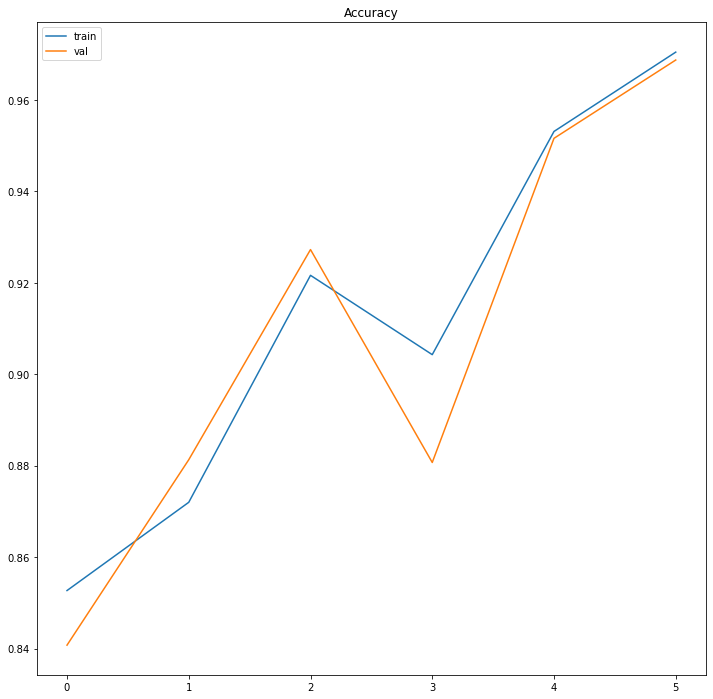

In [23]:
# Plotting Loss and Accuracy Graphs
plt.figure(figsize=(12, 12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 12))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Testing

In [24]:
test_data=pd.read_csv('C:/Users/Azerty/Desktop/Fake news detection/data/test_news.csv',index_col=0)
#preprocess the test data
test_data.fillna('0',inplace=True)
test_data['original_text']=test_data['title']+' '+test_data['text']
test_data.drop(columns=['author','text','title'],inplace=True)
test_data['tokenized_text'] = test_data.apply(lambda x: word_tokenize(x['original_text'].lower()),axis=1)
test_data.drop(columns=['original_text'],inplace=True)

In [25]:
test_data['tokenized_text']=test_data.apply(lambda x: process(x['tokenized_text']),axis=1)
X_test=test_data['tokenized_text'] 
y_test=test_data['label'] # label 

# text to sequence
X_test=tokenizer.texts_to_sequences(X_test)
X_test=pad_sequences(X_test,maxlen=1500)

# predict
y_pred= model.predict(X_test)

In [26]:
y_pred_list= [round(x[0]) for x in y_pred]

In [27]:
from sklearn.metrics import accuracy_score
# calculate the accuracy score
accuracy_score(y_pred_list,y_test)

0.9706730769230769